In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
dir_path = "../input/chest-xray-pneumonia/chest_xray/"

In [3]:
''' training path '''
train_p = os.path.join(dir_path, "train")

''' test path '''
test_p =os.path.join(dir_path, "test")

''' val path '''
val_p = os.path.join(dir_path, "val")

In [4]:
''' PNEUMONIA images '''
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")

''' NORMAL  images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [5]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='class', ylabel='count'>

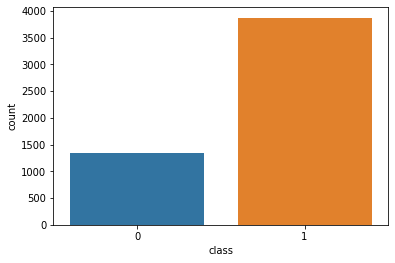

In [6]:
sns.countplot(df['class'],data=df)

In [7]:
''' Data Augmentation '''
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

In [8]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
''' lets see how model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [10]:
''' flow from directory '''
train_ds = train_ds.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_ds.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')

tes_ds = val_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
''' training '''
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 88s 795ms/step - loss: 11.0467 - accuracy: 0.6619 - val_loss: 4.7346 - val_accuracy: 0.5625
Epoch 2/20
100/100 [==============================] - 77s 768ms/step - loss: 0.5649 - accuracy: 0.8174 - val_loss: 0.3958 - val_accuracy: 0.9375
Epoch 3/20
100/100 [==============================] - 77s 762ms/step - loss: 0.3410 - accuracy: 0.8526 - val_loss: 0.3275 - val_accuracy: 0.8750
Epoch 4/20
100/100 [==============================] - 77s 762ms/step - loss: 0.2956 - accuracy: 0.8783 - val_loss: 0.2661 - val_accuracy: 0.8750
Epoch 5/20
100/100 [==============================] - 76s 762ms/step - loss: 0.2822 - accuracy: 0.8827 - val_loss: 1.4129 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 76s 762ms/step - loss: 0.2953 - accuracy: 0.8982 - val_loss: 1.1822 - val_accuracy: 0.6875
Epoch 7/20
100/100 [==============================] - 77s 762ms/step - loss: 0.2428 - accuracy: 0.8996 - val_loss: 6.5223 - val_a

In [13]:
''' evaluating model '''
accuracy = model.evaluate_generator(test_ds,624)[1]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [14]:
accuracy

0.8525640964508057

In [15]:
''' unfreezing layers '''
for layer in model1.layers:
    layer.trainable = True

In [16]:
'''Finetuning the model'''
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [17]:
''' training '''
model.fit(train_ds, steps_per_epoch = 50, epochs=100, validation_data=val_s)

Epoch 1/100
50/50 [==============================] - 44s 827ms/step - loss: 0.5159 - binary_accuracy: 0.7825 - val_loss: 1.4864 - val_binary_accuracy: 0.7500
Epoch 2/100
50/50 [==============================] - 41s 816ms/step - loss: 0.3430 - binary_accuracy: 0.8716 - val_loss: 0.4182 - val_binary_accuracy: 0.8125
Epoch 3/100
50/50 [==============================] - 41s 815ms/step - loss: 0.2455 - binary_accuracy: 0.8981 - val_loss: 0.5760 - val_binary_accuracy: 0.7500
Epoch 4/100
50/50 [==============================] - 41s 814ms/step - loss: 0.1858 - binary_accuracy: 0.9303 - val_loss: 0.1656 - val_binary_accuracy: 1.0000
Epoch 5/100
50/50 [==============================] - 41s 816ms/step - loss: 0.1788 - binary_accuracy: 0.9367 - val_loss: 0.4396 - val_binary_accuracy: 0.8125
Epoch 6/100
50/50 [==============================] - 41s 816ms/step - loss: 0.1999 - binary_accuracy: 0.9193 - val_loss: 0.7695 - val_binary_accuracy: 0.8125
Epoch 7/100
50/50 [==============================] -

In [55]:
''' evaluating model '''
final_acc = model.evaluate_generator(test_generator,624)[1]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [56]:
final_acc

0.942307710647583

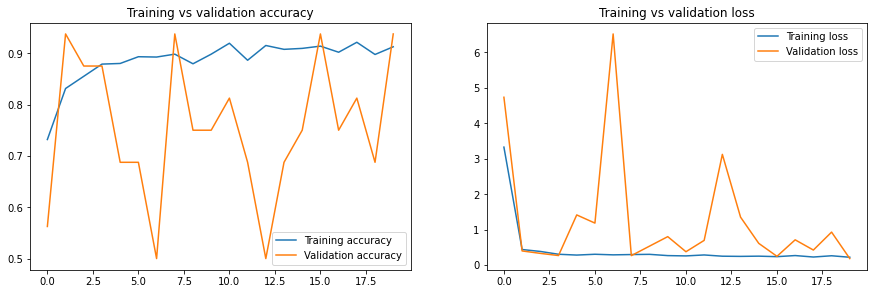

In [22]:
''' Training Accuracy and Validaion Accuracy graph '''
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()